In [1]:
import numpy as np
import meds

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

sns.set()

In [3]:
tilename = "DES0124-3332"
pizza_name = "/Users/beckermr/Downloads/DES0124-3332_r5191p01_r_pizza-cutter-slices.fits.fz"
stamp_name = "/Users/beckermr/Downloads/DES0124-3332_r4907p01_r_meds-Y6A1.fits.fz"
m = meds.MEDS(pizza_name)
mobj = meds.MEDS(stamp_name)

In [ ]:
print(m._fits.hdu_map["metadata"].read()["config"][0])

In [ ]:
plt.figure(figsize=(8, 8))

q = np.where(m['ra'] > 180.0)
m['ra'][q] = m['ra'][q] - 360.0

plt.plot(m['ra'], m['dec'], '.')
plt.xlabel('ra [deg]')
plt.ylabel('ra [deg]')

In [ ]:
istart = 2000
ncut = 5
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8, 8), sharex='col', sharey='col')
# typ = 'image' # 'weight', 'seg', 'bmask', 'ormask', 'noise' or 'psf'.

psfs = []
for i, ind in enumerate(range(istart, istart+ncut)):
    for j, typ in enumerate(["image", "noise", "bmask", "ormask", "psf"]):
        ax = axs[i, j]
        im = m.get_cutout(ind, 0, type=typ)
        if typ == "psf":
            im = im[13:-13, 13:-13]

        ax.imshow(np.arcsinh(im))
        ax.grid(False)
        ax.xaxis.set_visible(False)
        if typ == "psf":
            psfs.append(im)
            
        if typ == "image":
            ax.set_ylabel("nepoch: %d" % m["nepoch"][ind])
            ax.set_yticks([])
        else:
            ax.yaxis.set_visible(False)

        if i == 0:
            ax.set_title(typ)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("pizza.png")

In [ ]:
plt.figure()

msk = m["nepoch"] > 0
sns.distplot(np.array(m["nepoch"][msk], dtype="<f8"), kde=False)
ax = plt.gca()
ax.set_xlabel("# of epochs")
ax.set_title("%s r-band - median = %d" % (tilename, np.median(m["nepoch"][msk])))
plt.savefig("nepochs.png")

## go object by object

In [4]:
def _convert_to_index(row, col, dbox=100, edge=50):
    xind = (col.astype(int) - edge)//dbox
    yind = (row.astype(int) - edge)//dbox
    return xind + 99*yind

assert np.array_equal(_convert_to_index(m["orig_row"][:, 0], m["orig_col"][:, 0]), np.arange(len(m["orig_col"][:, 0]), dtype=int))

In [5]:
pizza_inds = _convert_to_index(mobj["orig_row"][:, 0], mobj["orig_col"][:, 0])

In [6]:
from meds.defaults import BMASK_EDGE
import tqdm

dnepoch = []
nepoch = []
for obj_ind, pizza_ind in tqdm.tqdm(enumerate(pizza_inds), total=len(pizza_inds)):
    if pizza_ind < 0 or pizza_ind >= 9801 or m["nepoch"][pizza_ind] <= 0:
        continue
    
    nepoch_obj = 0
    for msk_ind in range(1, mobj["ncutout"][obj_ind]):
        msk = mobj.get_cutout(obj_ind, msk_ind, type="bmask")
        if not np.any(msk & BMASK_EDGE):
            nepoch_obj += 1
    dnepoch.append(m["nepoch"][pizza_ind] - nepoch_obj)
    nepoch.append(nepoch_obj)

100%|██████████| 65306/65306 [00:30<00:00, 2134.01it/s]


<IPython.core.display.Javascript object>


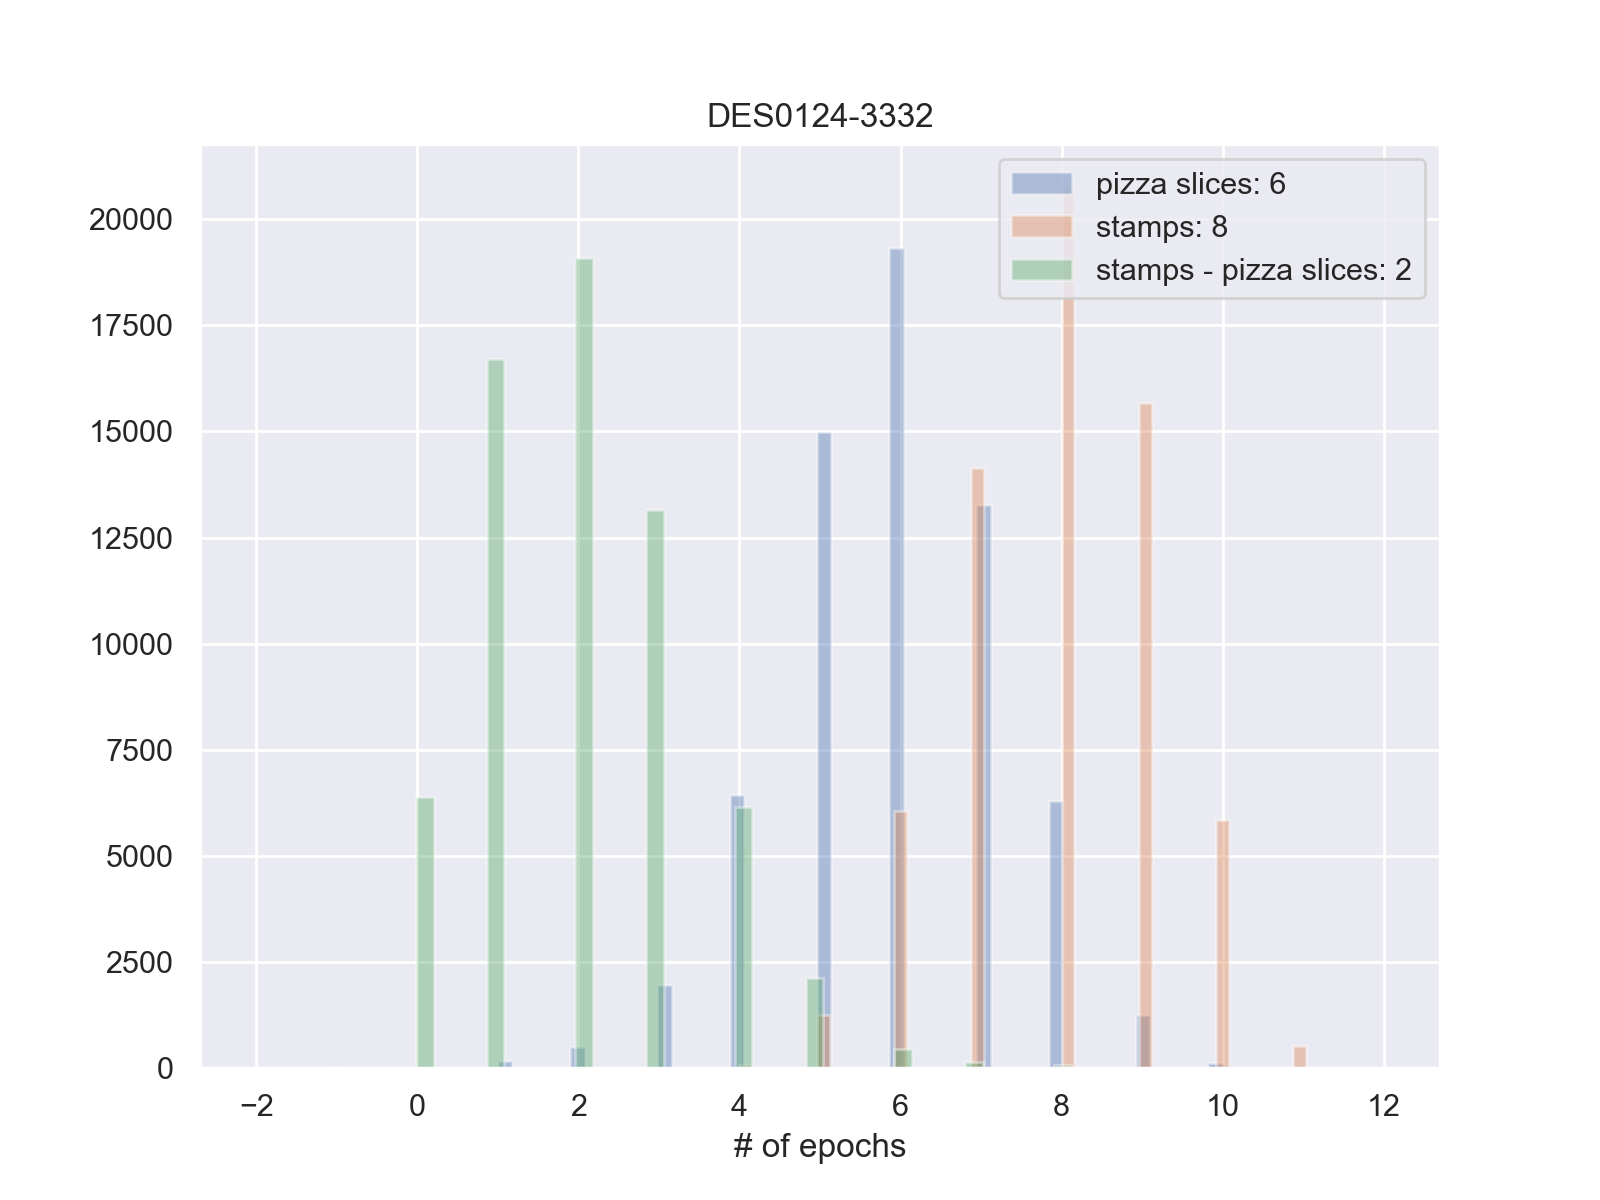

/Users/beckermr/miniconda3/envs/desy6/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'DES0124-3332')

In [7]:
plt.figure(figsize=(8, 6))
sns.distplot(
    np.array(dnepoch) + np.array(nepoch), 
    kde=False, 
    label="pizza slices: %d" % np.median(np.array(dnepoch) + np.array(nepoch))
)
sns.distplot(
    nepoch, 
    kde=False, 
    label="stamps: %d" % np.median(nepoch)
)
sns.distplot(
    -np.array(dnepoch), 
    kde=False, 
    label="stamps - pizza slices: %d" % (-np.median(dnepoch))
)

plt.legend()
plt.xlabel("# of epochs")
plt.savefig("ouch.png")
plt.title(tilename)

In [8]:
import fitsio

In [158]:
d = fitsio.read("hdata.fits")

<IPython.core.display.Javascript object>


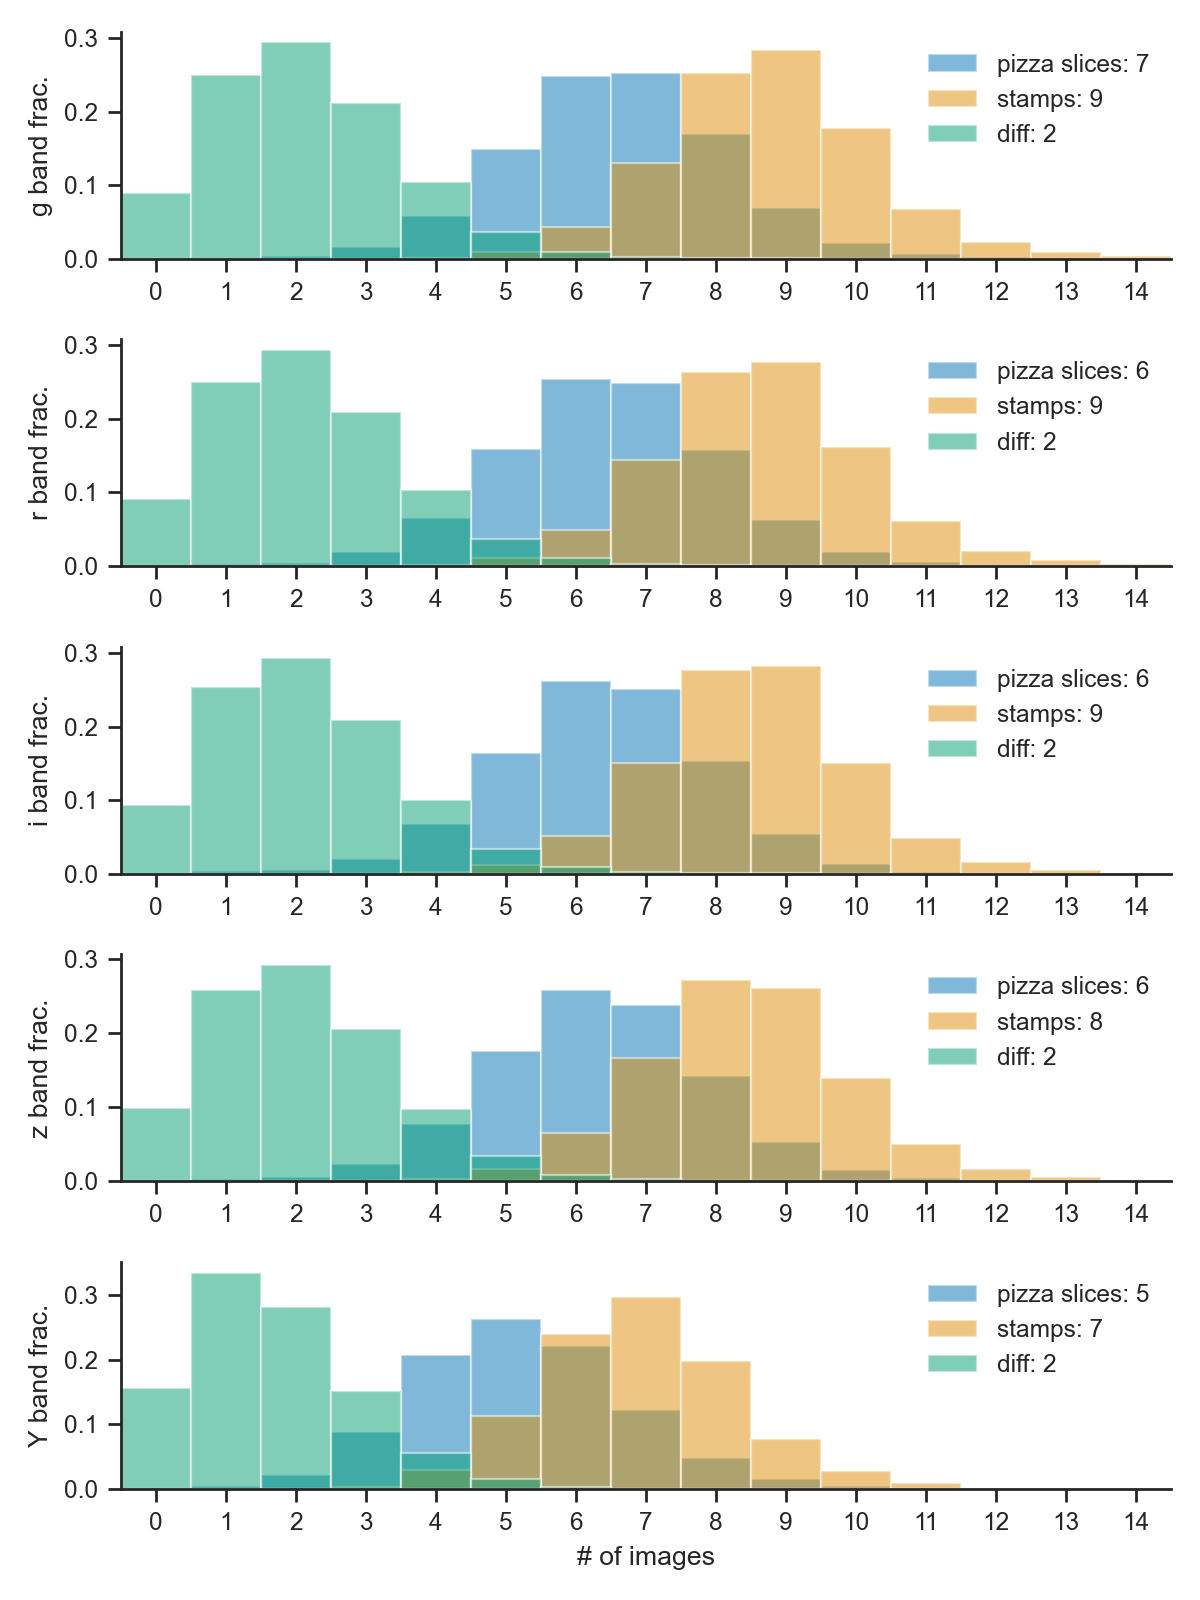

In [160]:
def _histogram_median(h, bin_edges):
    cuml = np.cumsum(h)
    tot = np.sum(h)
    mind = np.digitize(int(tot/2), cuml)
    bw = bin_edges[mind+1] - bin_edges[mind]
    return bin_edges[mind] + bw/2


sns.set_palette("colorblind")
sns.set_style("ticks")
sns.set_context("paper")

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(6, 8))

bloc = d["bin"][0]
msk = (bloc >= 0) & (bloc < 15)
nmsk = (-bloc >= 0) & (-bloc < 15)

bem = list(d["bin"][0][msk]-0.5) + [d["bin"][0][msk][-1]+0.5]
benm = list(-d["bin"][0][nmsk][::-1]-0.5) + [-d["bin"][0][nmsk][::-1][-1]+0.5]

for i, band in enumerate(list("grizY")):
    bmask = d["band"] == band
    ax = axs[i]
    res = ax.hist(
        bloc[msk], 
        weights=np.sum(d["pizza"][bmask][:, msk], axis=0)/np.sum(d["pizza"][bmask][:, msk]), 
        bins=bem,
        label="pizza slices: %d" % _histogram_median(np.sum(d["pizza"][bmask][:, msk], axis=0), bem),
        alpha=0.5,
    )
    ax.hist(
        bloc[msk], 
        weights=np.sum(d["stamp"][bmask][:, msk], axis=0)/np.sum(d["stamp"][bmask][:, msk]), 
        bins=bem,
        label="stamps: %d" % _histogram_median(np.sum(d["stamp"][bmask][:, msk], axis=0), bem),
        alpha=0.5,
    )
    ax.hist(
        -bloc[nmsk], 
        weights=np.sum(d["diff"][bmask][:, nmsk], axis=0)/np.sum(d["diff"][bmask][:, nmsk]), 
        bins=benm,
        label="diff: %d" % _histogram_median(np.sum(d["diff"][bmask][:, nmsk], axis=0)[::-1], benm),
        alpha=0.5,
    )
    ax.legend(frameon=False)
    ax.set_xticks(bloc[msk])
    ax.set_xticklabels(["%d" % b for b in bloc[msk]])
    ax.set_xlim(-0.5, bloc[msk].max()+0.5)
    if i == 4:
        ax.set_xlabel("# of images")
    ax.set_ylabel("%s band frac." % band)
        
fig.tight_layout()

sns.despine()
plt.savefig("pizza_vs_stamps.pdf")

In [70]:
msk = d["bin"][0] < -2
bmsk = (d["band"] == "r") | (d["band"] == "i") | (d["band"] == "z")
np.sum(d["diff"][bmsk][:, msk])/np.sum(d["diff"][bmsk])

0.3485536

In [149]:
h = np.sum(d["diff"][bmask][:, nmsk], axis=0)[::-1]
cuml = np.cumsum(h)
tot = np.sum(h)

In [150]:
benm[np.digitize(int(tot/2), cuml)]

1.5

In [151]:
np.sum(d["diff"][bmask][:, nmsk], axis=0)[::-1]

array([4.55030e+05, 9.79040e+05, 8.09182e+05, 4.22762e+05, 1.58975e+05,
       4.28900e+04, 1.06650e+04, 2.23200e+03, 3.58000e+02, 5.90000e+01,
       1.00000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
      dtype=float32)

In [152]:
benm

[-0.5,
 0.5,
 1.5,
 2.5,
 3.5,
 4.5,
 5.5,
 6.5,
 7.5,
 8.5,
 9.5,
 10.5,
 11.5,
 12.5,
 13.5,
 14.5]

In [153]:
np.digitize?

In [156]:
ax.legend?